# P05: Least squares and regression

In the last challenge we learned how to determine photometric redshifts of galaxies. In this challenge we are going to learn how to determine spectroscopic redshifts. 

When assigning redshifts to galaxies with a full observed spectrum, one typically fits model spectra for the rest-frame galaxy spectrum to the observed one while accounting for the redshift of the wavelengths. In this challenge, we first want to try to fit a local spectrum with templates using a linear regression and least-squares before trying to estimate the redshift of a redshifted spectrum.

Below you can see an example SDSS spectrum and an illustration of the method to determine spectroscopic redshifts. Both figures are taken from [Bolton et al., 2012](https://ui.adsabs.harvard.edu/abs/2012AJ....144..144B/abstract).

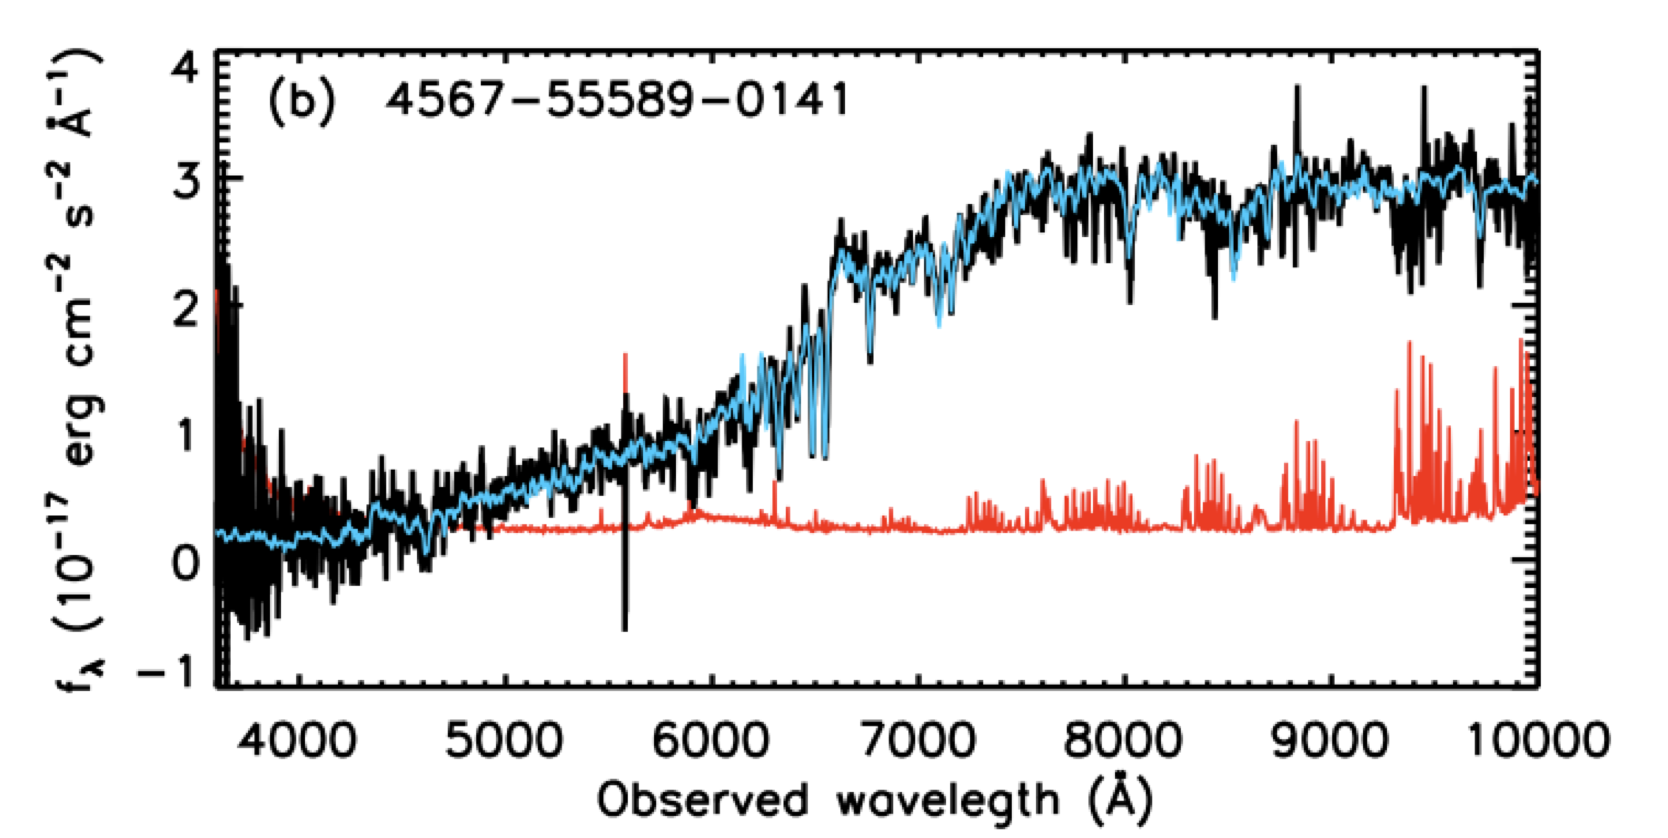

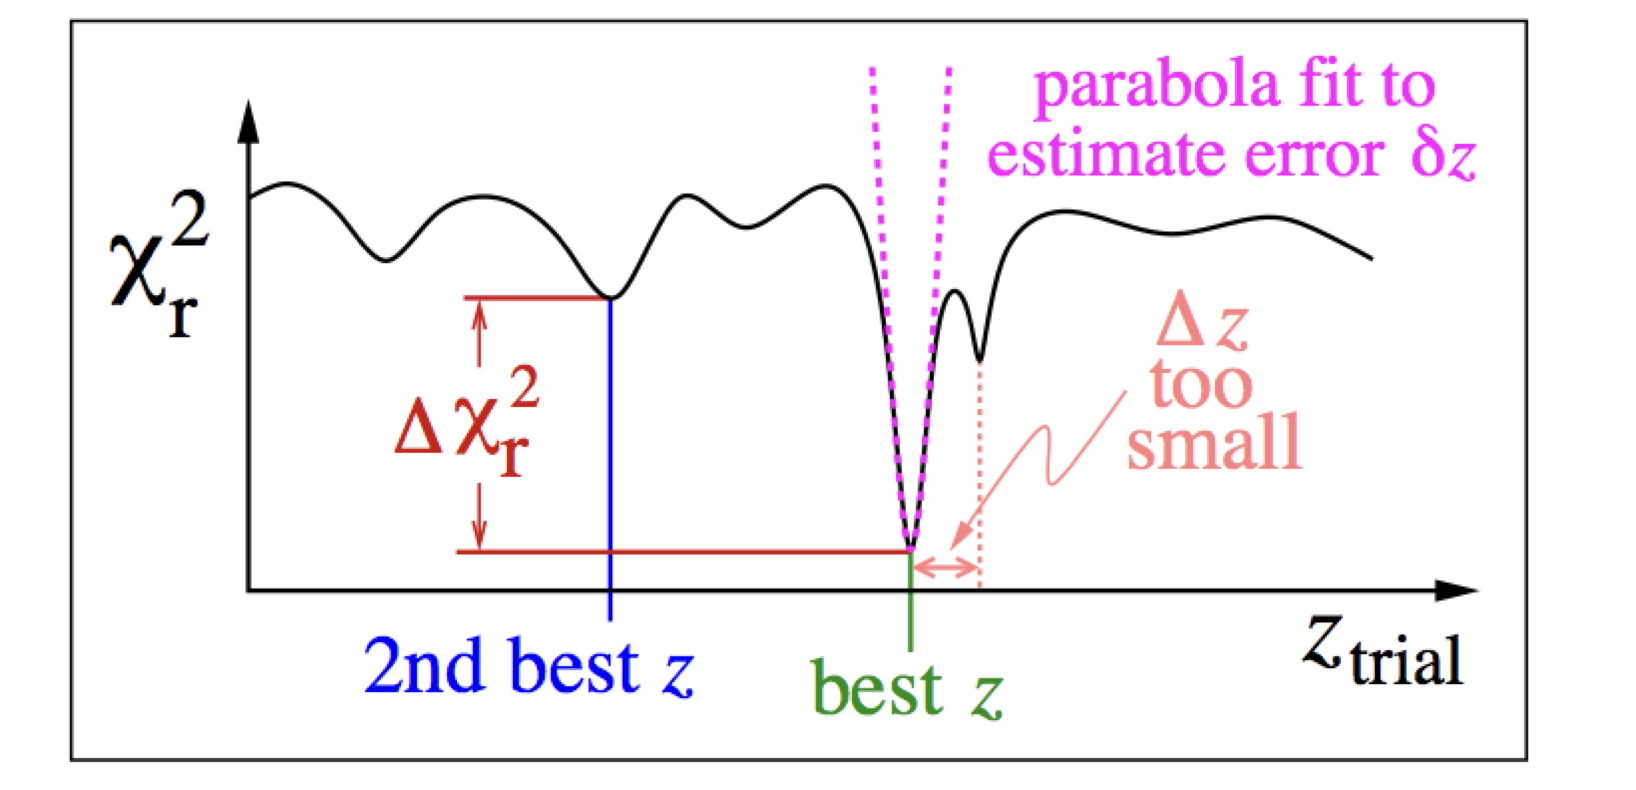

## Problem 1: Extracting and plotting galaxy spectrum templates

In the `data` directory you can find a fits-file containing the model spectra, `k_nmf_derived.newdefaults.fits`, we want to use to fit the observed spectrum later. You'll also find a python script in the `scripts` directory that shows you how to work with the templates. 

Extract and plot the unsmoothed templates with all components included.

In [15]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from IPython.display import display, Latex

params = {'axes.linewidth'  :  1.5,
		  'xtick.labelsize' : 19,
		  'ytick.labelsize' : 19,
		  'legend.fontsize' : 19,
		  'axes.labelsize'  : 25,
		  'axes.titlesize'  : 25,
		  'errorbar.capsize':  4,
		  'figure.figsize'  : (10,10),
		  'axes.grid'       : True,
		  'grid.linewidth'  : 1}
plt.rcParams.update(params)
	

In [2]:
# open files, template and coefficients
hdulist = fits.open('data/k_nmf_derived.newdefault.fits')

# read in templates
lam	 		= hdulist[11].data
tspec_v0		= hdulist[1].data      # no smoothing
tspec_v0_nl		= hdulist[2].data      # no smoothing without lines
tspec_v0_nd		= hdulist[3].data      # no smoothing without dust
tspec_v0_nd_nl	= hdulist[4].data      # no smoothing without lines and dust
tspec_v300		= hdulist[5].data      # smoothing
tspec_v300_nl	= hdulist[6].data      # smoothing without lines
tspec_v300_nd	= hdulist[7].data      # smoothing without dust 
tspec_v300_nd_nl = hdulist[8].data     # smoothing without line without dust
lspec_v300		= hdulist[9].data      # add lines ?

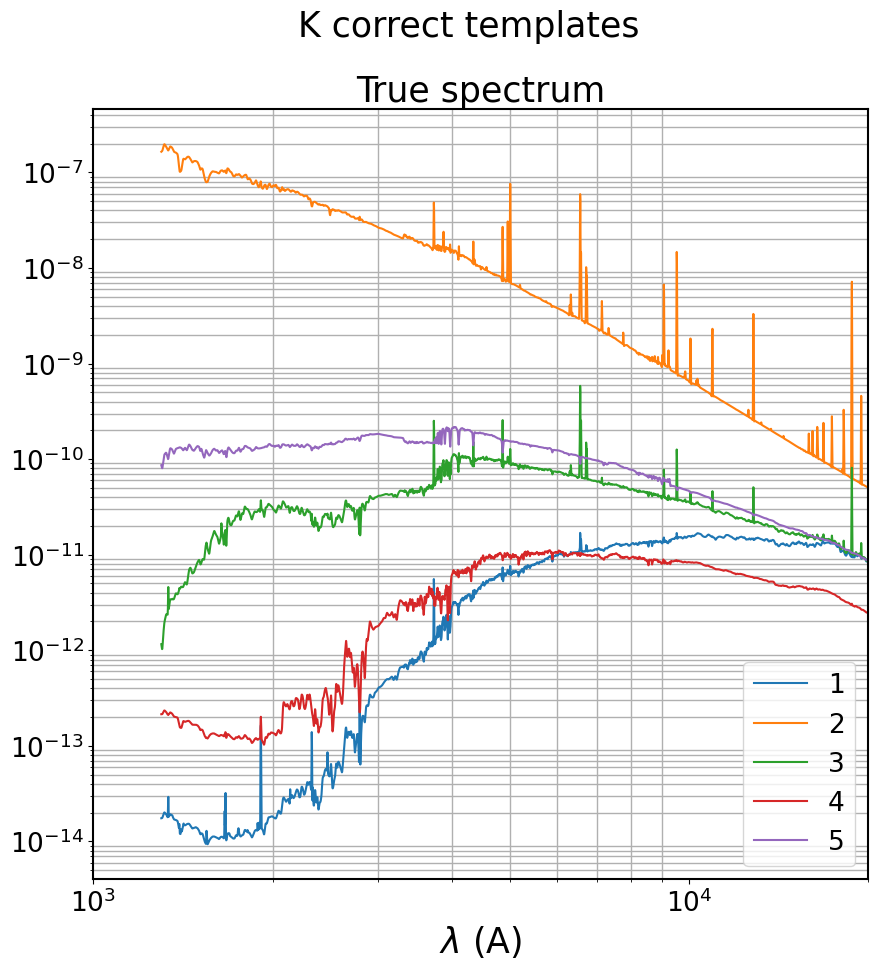

In [3]:
plt.figure(figsize=(10,10))
plt.suptitle('K correct templates', fontsize = 25)

for i in range(5):
    plt.plot(lam, tspec_v0[i], label=f'{i+1}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1000, 20000)
plt.legend(loc='lower right')
plt.xlabel('$\lambda$ (A)')
plt.title('True spectrum')
plt.grid(which = 'both')
plt.show()

## Problem 2: Fitting a local spectrum

In this problem, we will fit a local (i.e. redshift zero) galaxy spectrum, which we assume to be a linear combination of the template spectra given in problem 1. The spectrum can be found in the `data` directory in `localspectrum.txt`.

(i) Formulate and solve the least squares problem of finding the best fit amplitudes of the templates from problem 1.  

(ii) Implement your own linear least squares solver and compute the best-fit template amplitudes for `localspectrum.txt`.

In [4]:
def get_M(Y):
    """
    Set matrix M, under the assumption of linear dependece
    
    input:
    - Y (array): measured data set

    return:
    - Matrix M
    """
    M = np.zeros((len(Y),6))
    for i in range(len(Y)):
        M[i,0] = 1
        M[i,1] = tspec_v0[0,i]
        M[i,2] = tspec_v0[1,i]
        M[i,3] = tspec_v0[2,i]
        M[i,4] = tspec_v0[3,i]
        M[i,5] = tspec_v0[4,i]
    return M

def get_amps(M,Y):
    '''
    calculate amplitudes theta_0 to theta_5
    assume equal sigmas for the data thus the Covariance matrix is the Unity matrix

    input:
    - M (Matrix): Matrix M
    - Y (array):  neasured data

    return:
    - vector with amplitutes theta_0 to theta_5
    '''
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(M),M)),np.transpose(M)),Y)
    
def get_result(A): 
    """
    compute resulting spectrum
    
    input:
    -A (array): amplitudes calculated with get_amps

    return:
    -resulting fitted spectrum (array)
    """
    return A[0] + A[1]*tspec_v0[0] + A[2]*tspec_v0[1] + A[3]*tspec_v0[2] + A[4]*tspec_v0[3] + A[5]*tspec_v0[4]
    
def get_residual(data,model):
    """
    Calculate the residual between the data and the best fit model
    
    input:
    - data  (array): measurement data
    - model (array): best fit model to data

    return:
    - sqrt of the mean of the difference between model and data point squared
      ( mean is needed to account for unequal size of data sets)
    """
    return np.sqrt(np.mean((data-model)**2))

def lamda(z):
    """
    Calculate rest wavelengths of modelset
    input:
    - redshift z

    return:
    - rest wavelengths corresponding to measured wavelengths w.r.t. z
    """
    return z*lam+lam 

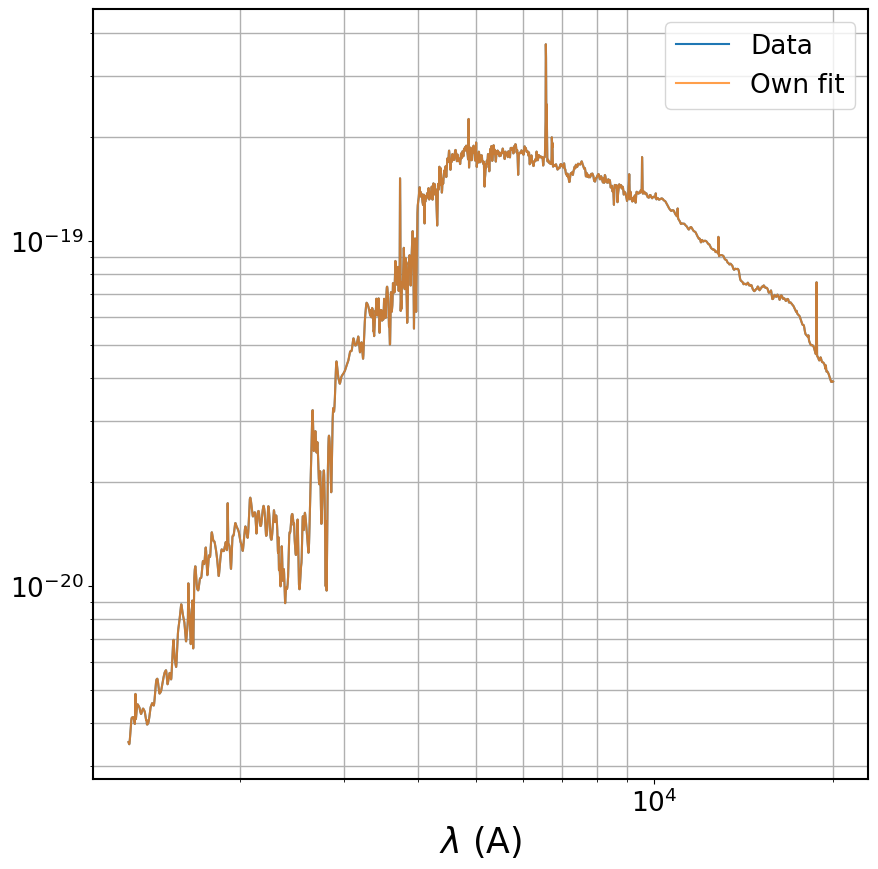

In [5]:
data      = np.genfromtxt('data/localspectrum.txt')
# get results from own impleted fitting routine
result    = get_result(get_amps(get_M(data),data))

# plot Data together with both best fits from two different methods 
plt.figure(figsize=(10,10))
plt.plot(lam,data,      label = 'Data')
plt.plot(lam,result,    label = 'Own fit',   alpha = 0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\lambda$ (A)')
plt.legend()
plt.grid(which = 'both')
plt.show()


(iii) Compare your results to what you obtain using `numpy`'s implementation. 

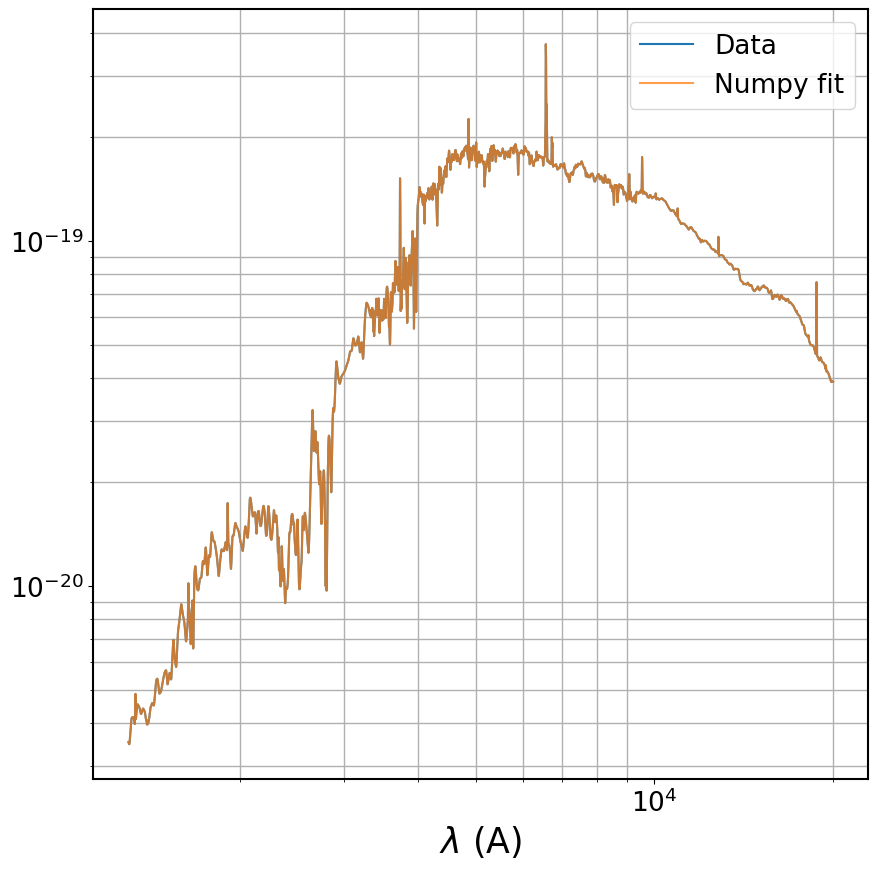

In [6]:
# use numpy implementation to obtain fit
np_result = get_result(np.linalg.lstsq(get_M(data),data, rcond = -1)[0])

# plot Data together with both best fits from two different methods 
plt.figure(figsize=(10,10))
plt.plot(lam,data,      label = 'Data')
plt.plot(lam,np_result, label = 'Numpy fit', alpha = 0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\lambda$ (A)')
plt.legend()
plt.grid(which = 'both')
plt.show()

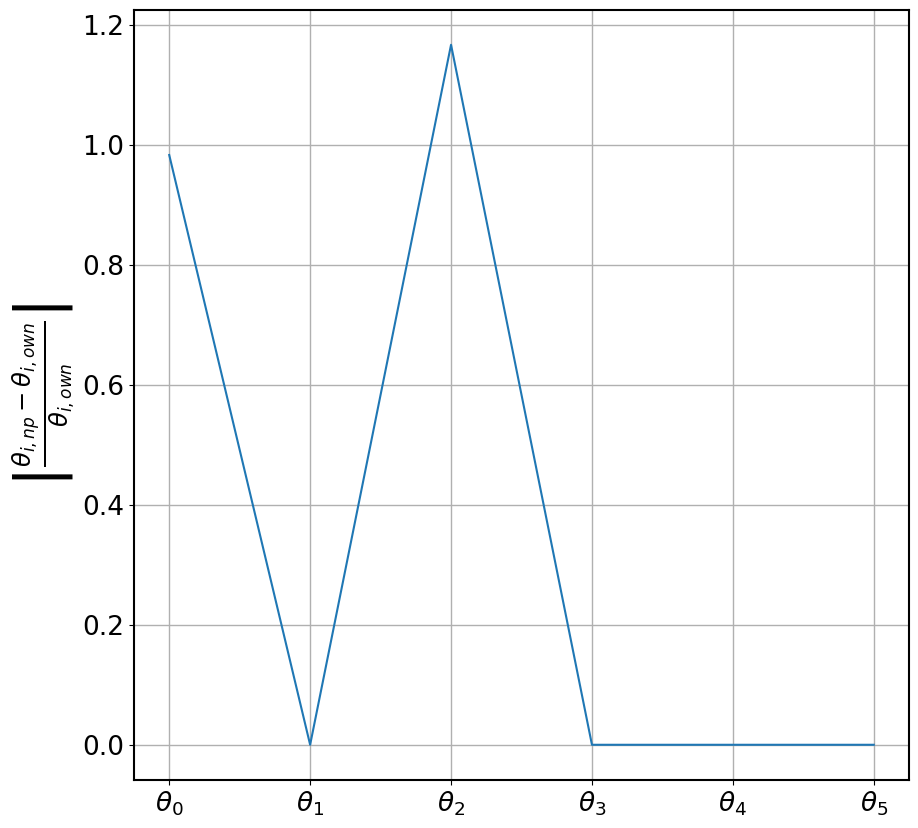

In [7]:
np_amps  = np.linalg.lstsq(get_M(data),data, rcond = -1)[0]
own_amps = get_amps(get_M(data),data)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0,1,2,3,4,5],np.abs((np_amps-own_amps)/own_amps))
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['$\\theta_0$','$\\theta_1$','$\\theta_2$','$\\theta_3$','$\\theta_4$','$\\theta_5$'])
plt.ylabel('$\\left|\\frac{\\theta_{i,np}-\\theta_{i,own}}{\\theta_{i,own}}\\right|$')
plt.show()

The resulting, fitted spectrum is exactly the same. There is no difference between the own implemented fit and the fit obtained using the numpy implementations. Yet there is a difference in the obtained amplitudes $\theta_i$, shown in the plot above.

## Problem 3: Fitting a redshifted spectrum

The file `redshiftedspectrum.txt` contains a redshifted spectrum. Fitting both redshift and template amplitudes is no longer a linear problem. 

Find the redshift by solving the linear problem of problem 2 on a grid of redshifts between 0 and 1.

In [8]:
redshift_data = np.genfromtxt('data/redshiftedspectrum.txt')

# set redshift grid with 0 < z < 1 in steps of 0.01
z_grid = np.arange(0.01,1,0.01)

# create empty array for residuals
residuals  = []

# loop over redshift grid
for z in z_grid:
    # determine shift (in means of list entries) in the wavelengths caused by redshift
    shift = np.argwhere(lam >= lamda(z)[0])[0][0]
        
    # only take redshift data above determined shift into account
    Y = redshift_data[shift:]
    M = get_M(Y)
    # drop the last SHIFT number of entries of the best fit model
    # to have same amount of entries in measured and model data
    result = get_result(get_amps(get_M(Y),Y))[:-shift]

    residuals.append(get_residual(Y,result))
    if get_residual(Y,result) <= min(residuals):
        z_result     = z
        data_result  = get_result(get_amps(get_M(Y),Y))
        min_shift    = shift
        amps_result  = get_amps(get_M(Y),Y)

<IPython.core.display.Latex object>

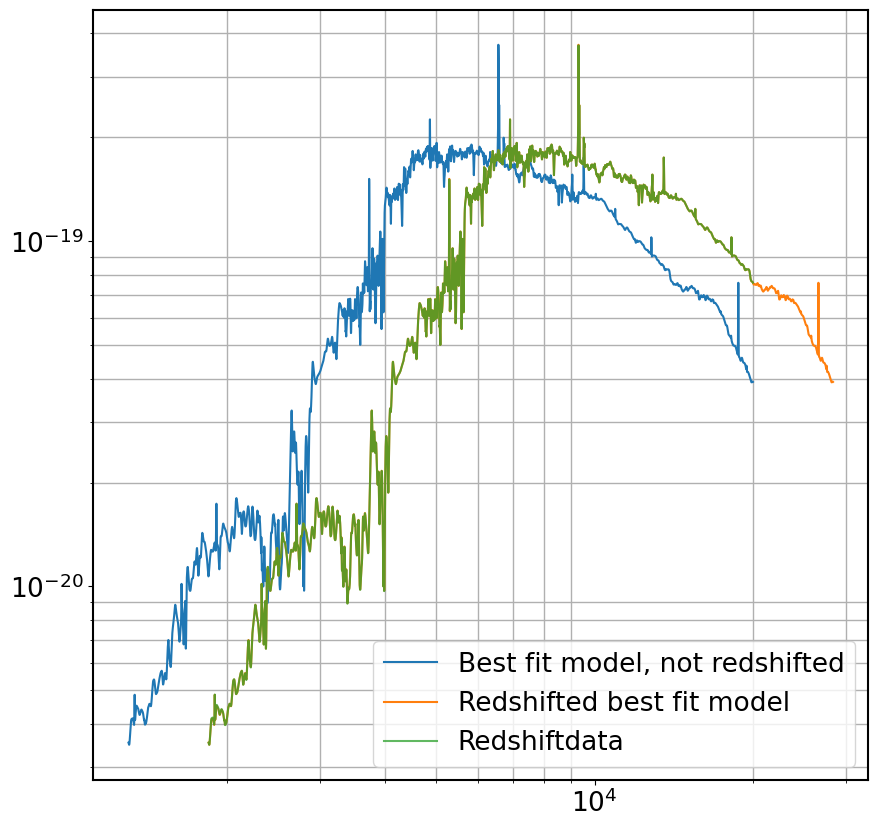

In [19]:
display(Latex(f'The redshift of the best fit model is z = {z_result:0.2f} $\pm$ 0.01'))
plt.figure(figsize=(10,10))
plt.plot(lamda(0),             data_result,               label = 'Best fit model, not redshifted')
plt.plot(lamda(z_result),      data_result,               label = 'Redshifted best fit model')
plt.plot(lamda(0)[min_shift:], redshift_data[min_shift:], label = 'Redshiftdata', alpha = 0.75)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(which = 'both')
plt.show()

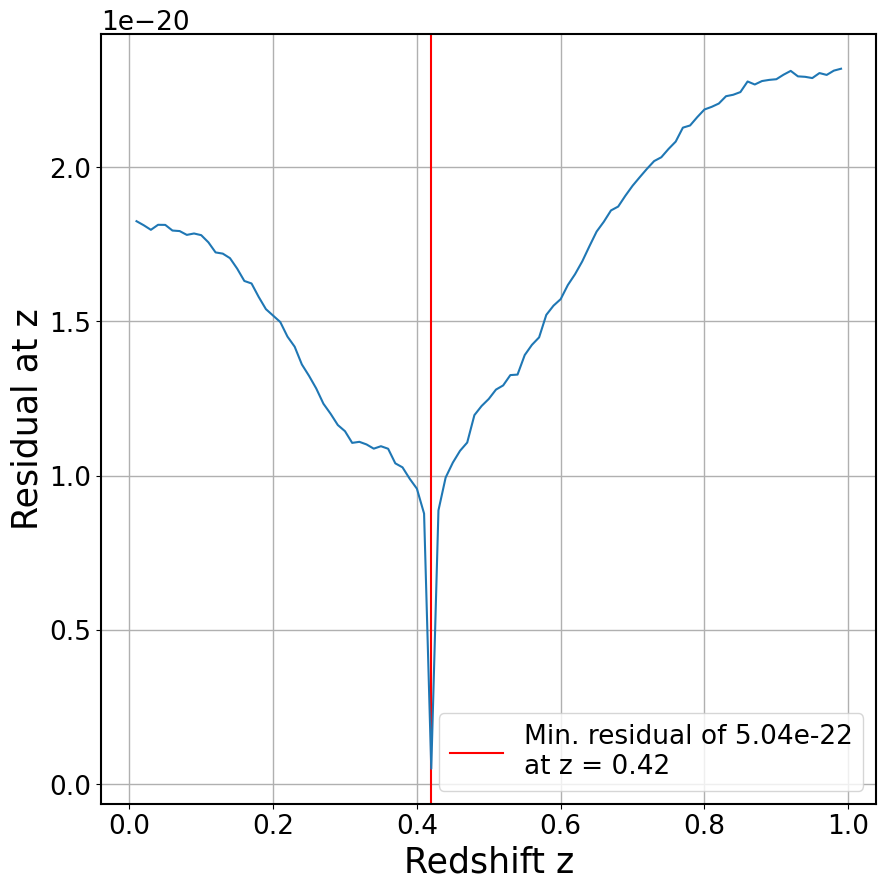

In [14]:
plt.figure(figsize=(10,10))
plt.axvline(z_result, color = 'red', label = f'Min. residual of {min(residuals):0.2e}\nat z = 0.42')
plt.plot(z_grid,residuals)
plt.xlabel('Redshift z')
plt.ylabel('Residual at z')
plt.legend()
plt.show()